In [1]:
# from tile_match_gym.tile_match_env import TileMatchEnv
import numpy as np
import gymnasium as gym
from gymnasium.envs.registration import register
from copy import deepcopy
from numba import njit
from tile_match_gym.tile_match_env import TileMatchEnv
from collections import defaultdict
# register(id="TileMatch-v0", entry_point="tile_match_gym.tile_match_env:TileMatchEnv")
from tqdm import tqdm
import matplotlib.pyplot as plt
# % matplotlib inline
from tile_match_gym.wrappers import ProportionRewardWrapper, OneHotWrapper, MinOneHotWrapper

In [58]:
obs["board"][:, 0, 0]

array([0., 0., 0., 1., 0., 0., 1.])

array([], shape=(0, 5, 5), dtype=float64)

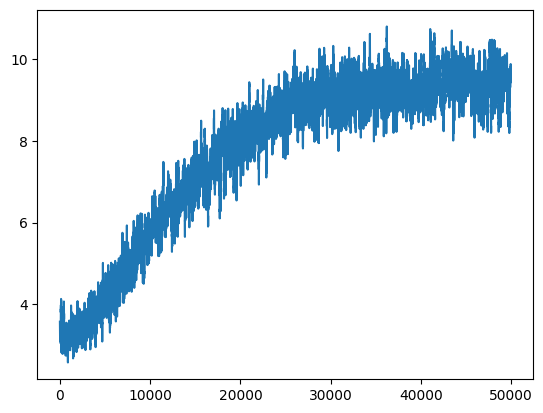

In [ ]:
plt.plot(moving_average(r, 50))

In [59]:
env.unwrapped.board.board[0]

array([[3, 1, 5],
       [3, 4, 1],
       [2, 5, 5],
       [5, 3, 2]])

In [75]:
env = TileMatchEnv(4, 3, 5, 10, [], [], seed=1)
env = OneHotWrapper(env)
assert env.observation_space["board"].shape == (5 + 2, 4, 3)
assert env.observation_space["num_moves_left"].n == 11

obs, info = env.reset()

assert np.array_equal(env.unwrapped.board.board[0], #
                      np.array([[3, 1, 5], 
                                [3, 4, 1],
                                [2, 5, 5],
                                [5, 3, 2]]))


# Check colours
assert np.array_equal(obs["board"][:, 0, 0], np.array([0, 0, 0, 1, 0, 0, 1], dtype=np.float32)), obs["board"][:, 0, 0]
assert np.array_equal(obs["board"][:, 0, 1], np.array([0, 1, 0, 0, 0, 0, 1], dtype=np.float32)), obs["board"][:, 0, 1]
assert obs["num_moves_left"] == 10


env = TileMatchEnv(5, 5, 3, 10, ["bomb"], [], seed=2)
env = OneHotWrapper(env)
obs, info = env.reset()

print(env.unwrapped.board.board)
assert np.array_equal(obs["board"][:, 2, 2], np.array([0, 1, 0, 0, 1, 0], dtype=np.float32)), obs["board"][:, 2, 2]




[[[3 3 2 2 1]
  [3 3 1 2 3]
  [2 2 1 3 2]
  [3 1 3 1 1]
  [2 3 2 2 1]]

 [[1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]
  [1 1 1 1 1]]]


AssertionError: [0. 1. 0. 0. 0. 1.]

In [72]:
obs["board"].shape

(6, 5, 5)

In [63]:
env.unwrapped.num_colours

5

In [2]:
env = gym.make("TileMatch-v0", num_rows=3, num_cols=3, num_colours=2, num_moves=10, colour_specials=["vertical_laser", "horizontal_laser", "bomb"], colourless_specials=["cookie"])
env = ProportionRewardWrapper(env)
env = OneHotWrapper(env)

In [3]:
env.board.board

c:\Users\ap2078\AppData\Local\miniconda3\envs\tile_match_gym\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.board to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.board` for environment variables or `env.get_wrapper_attr('board')` that will search the reminding wrappers.
  logger.warn(


AttributeError: 'Board' object has no attribute 'board'

In [5]:
obs, _ = env.reset()

obs["board"].shape

(8, 3, 3)

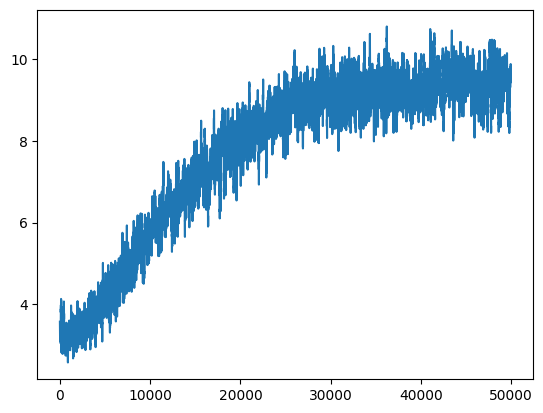

In [ ]:
plt.plot(moving_average(r, 50))

In [7]:
env.env.board.board

array([[[2, 2, 1],
        [1, 2, 1],
        [2, 1, 2]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]])

In [39]:
class QLearningAgent:
    def __init__(self, lr, epsilon, gamma, num_actions, rng):
        self.lr = lr
        self.epsilon = epsilon
        self.gamma = gamma
        self.num_actions = num_actions
        self.q_table = defaultdict(lambda: np.zeros(self.num_actions, dtype=np.float32))
        self.rng = rng

    def choose_action(self, obs, effective_actions = None):
        # effective_actions = None
        s = self._preprocess_obs(obs)
        if self.rng.random() < self.epsilon:
            if effective_actions == None:
                # print("random over all")
                return self.rng.choice(self.num_actions)
            else:
                # print("random over effectives")
                return self.rng.choice(effective_actions)
        else:
            q_vals = self.q_table[s]
            if effective_actions != None:
                # print("Argmax over effectives")
                # print(q_vals, effective_actions, q_vals[effective_actions])
                qs = q_vals[effective_actions]
                # print(qs==qs.max())
                return effective_actions[self.rng.choice(np.flatnonzero(qs == qs.max()))]
            else:
                # print("Argmax over all", )
                return self.rng.choice(np.flatnonzero(q_vals == q_vals.max()))
            
    def update(self, obs, action, reward, next_obs, done):
        s = self._preprocess_obs(obs)
        next_s = self._preprocess_obs(next_obs)
        q_vals = self.q_table[s]
        next_q_vals = self.q_table[next_s]
        q_target = reward + self.gamma * (1-done) * next_q_vals.max()
        self.q_table[s][action] += self.lr * ( q_target - q_vals[action])

    def _preprocess_obs(self, obs):
        board, num_moves = obs["board"], obs["num_moves_left"]
        o = board.flatten().tolist() + [num_moves]
        return tuple(o)


In [56]:
def run_episode(agent, env, obs_seen):
    obs, info = env.reset()
    done = False
    total_reward = 0
    num_effective_actions = 0
    
    obs_seen[agent._preprocess_obs(obs)] += 1
    while True:
        action = agent.choose_action(obs)
        next_obs, reward, done, _, info = env.step(action)
        obs_seen[agent._preprocess_obs(next_obs)] += 1
        agent.update(obs, action, reward, next_obs, done)
        num_effective_actions += int(reward > 0)
        total_reward += reward

        if done:
            break
        else:
            obs = next_obs
    return total_reward, num_effective_actions, obs_seen


def train(agent, num_episodes:int = 1000):
    env = gym.make("TileMatch", num_rows=3, num_cols=2, num_colours=2, num_moves=10, colour_specials=[], colourless_specials=[])
    env = ProportionRewardWrapper(env)
    epi_r = np.zeros(num_episodes)
    obs_seen = defaultdict(int)
    num_effective_actions_arr = np.zeros(num_episodes)
    num_shuffled = np.zeros(num_episodes)
    print_eps = True
    for i in tqdm(range(num_episodes)):
        total_reward, num_effective_actions, obs_seen = run_episode(agent, env, obs_seen)
        if agent.epsilon > 0.05:
            agent.epsilon *= 0.9999
        elif print_eps:
            print(f"Epsilon is low at episode {i}")
            print_eps = False
        epi_r[i] = total_reward
        num_effective_actions_arr[i] = num_effective_actions
    return epi_r, num_effective_actions_arr, obs_seen, agent

In [86]:
rng = np.random.default_rng(0)
agent = QLearningAgent(lr=0.25, epsilon=1, gamma=0.7, num_actions=env.num_actions, rng=rng)
r, eff_a, obs_seen, agent = train(agent, 100_000)

c:\Users\ap2078\AppData\Local\miniconda3\envs\tile_match_gym\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.num_actions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_actions` for environment variables or `env.get_wrapper_attr('num_actions')` that will search the reminding wrappers.
  logger.warn(
 30%|███       | 30004/100000 [01:50<04:59, 233.41it/s]

Epsilon is low at episode 29956


100%|██████████| 100000/100000 [07:08<00:00, 233.62it/s]


In [88]:
r.max()

24.22222222222222

In [48]:
def moving_average(data, window_size):
    weights = np.repeat(1.0, window_size) / window_size
    return np.convolve(data, weights, 'valid')

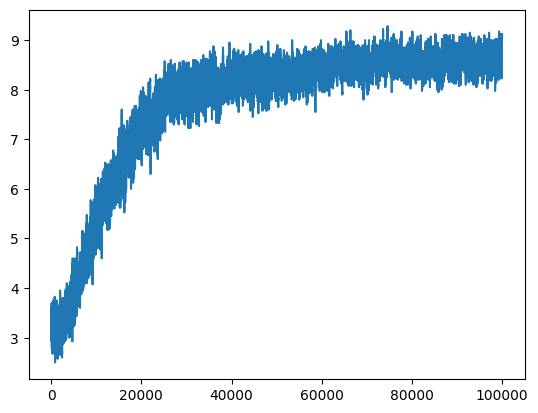

In [95]:

plt.plot(moving_average(eff_a, 40))

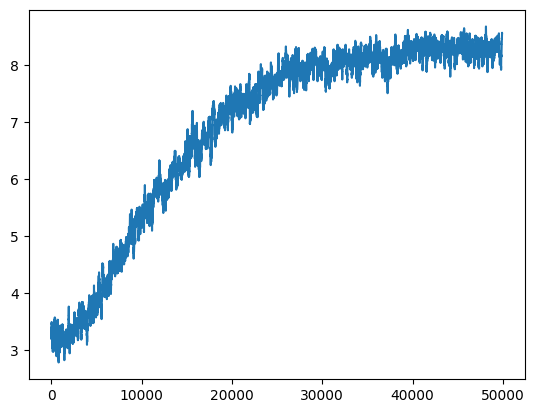

In [83]:
plt.plot(moving_average(eff_a, 100))

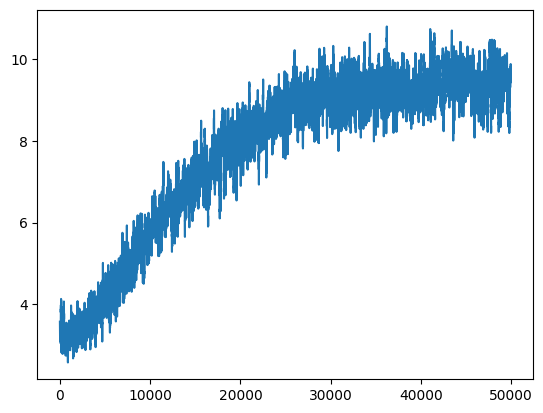

In [84]:
plt.plot(moving_average(r, 50))

In [ ]:
# Plot rolling averages.
# Run for longer to see if the agent explores enough.

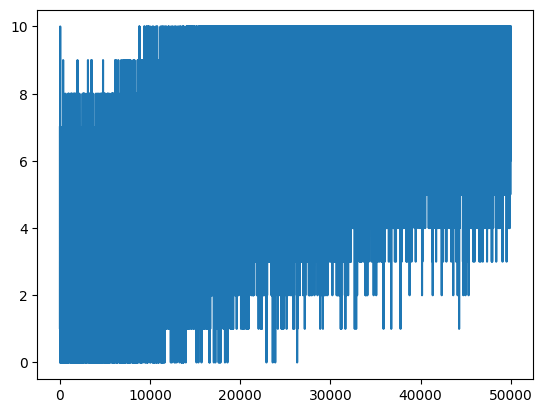

In [85]:
plt.plot(eff_a)

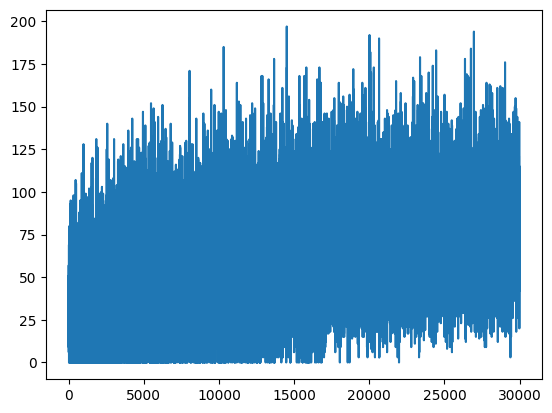

In [9]:
plt.plot(r)

In [22]:
obs_seen

defaultdict(int,
            {(1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10): 116,
             (1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9): 43,
             (1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8): 70,
             (1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7): 67,
             (1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6): 104,
             (1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5): 75,
             (1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4): 53,
             (1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3): 140,
             (2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2): 58,
             (2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1): 89,
             (2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0): 119,
             (2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10): 107,
             (2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,

In [29]:
o = sorted(obs_seen.items(), key = lambda x : x[1], reverse=False)


In [30]:
o

[((2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6), 3),
 ((2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5), 8),
 ((1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6), 12),
 ((1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7), 13),
 ((1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3), 13),
 ((2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7), 13),
 ((1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8), 14),
 ((2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5), 15),
 ((1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5), 16),
 ((2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4), 16),
 ((2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5), 19),
 ((2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6), 19),
 ((1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3), 19),
 ((1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4), 20),
 ((1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7), 20),
 ((2, 1, 1, 

In [27]:
agent.epsilon

0.04996170339735633

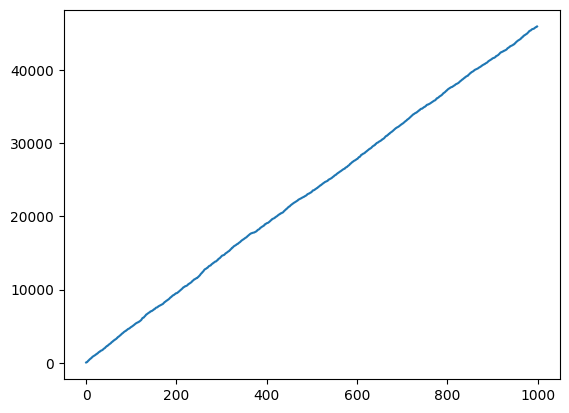

In [26]:
plt.plot(np.cumsum(r))

In [16]:
obs, info =  env.reset()
obs, info

(OrderedDict([('board',
               array([[[1, 2, 2],
                       [2, 1, 2],
                       [2, 1, 1]],
               
                      [[1, 1, 1],
                       [1, 1, 1],
                       [1, 1, 1]]])),
              ('num_moves_left', 10)]),
 {'effective_actions': [0, 1, 6]})

In [17]:
agent.q_table[agent._preprocess_obs(obs)]

array([0. , 2.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
      dtype=float32)

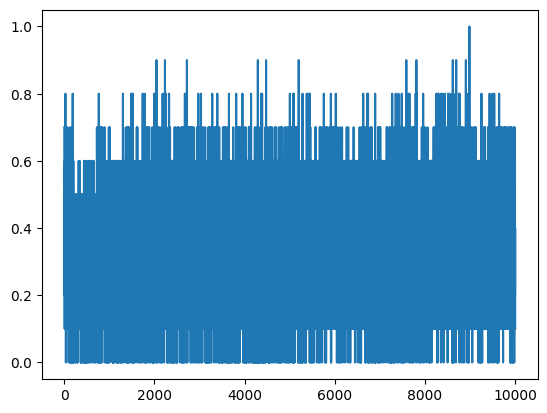

In [19]:
plt.plot(eff_a / 10)

In [182]:
env = TileMatchEnv(3, 3, 2, 5, [], [], 1)
env.reset()
env.board.board[0] = np.array([[1, 2, 2], [2, 1, 1], [2, 2, 1]])

effective_actions = env._get_effective_actions()
print(effective_actions)
assert effective_actions == [0, 6, 8]#

env = TileMatchEnv(3, 3, 2, 10, colour_specials=["vertical_laser", "horizontal_laser", "bomb"], colourless_specials=["cookie"])
env.reset()
env.board.board[0] = np.array([[1, 2, 2], [2, 1, 1], [2, 2, 1]])
assert effective_actions == [0, 6, 8]

[0, 6, 8]


In [176]:
env.step(1)

(OrderedDict([('board',
               array([[[1, 2, 2],
                       [2, 1, 1],
                       [2, 2, 1]],
               
                      [[1, 1, 1],
                       [1, 1, 1],
                       [1, 1, 1]]])),
              ('num_moves_left', 9)]),
 0,
 False,
 False,
 {'is_combination_match': False,
  'num_new_specials': 0,
  'num_specials_activated': 0,
  'shuffled': False,
  'effective_actions': [0, 6, 8]})

In [109]:
env.step(4)

(OrderedDict([('board',
               array([[[1, 1, 2],
                       [1, 1, 2],
                       [2, 2, 1]],
               
                      [[1, 1, 1],
                       [1, 1, 1],
                       [4, 4, 1]]])),
              ('num_moves_left', 6)]),
 16,
 False,
 False,
 {'is_combination_match': False,
  'num_new_specials': 2,
  'num_specials_activated': 0,
  'shuffled': False,
  'effective_actions': [5, 10, 11]})